In [1]:
## Import

In [2]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
## Import network

In [4]:
network = 'stkl_no_control'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [5]:
wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
wn.options.hydraulic.demand_model = 'DD' #dynamic demand model
results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
head = results.node['head']
demand = results.node['demand']
demand = np.maximum(demand, 0)
num_nodes = wn.num_nodes

In [6]:
timesteps = demand.index.tolist()

In [7]:
num_nodes

1106

In [8]:
monitor_point = pd.read_excel('Monitor_points.xlsx')
monitor_b = monitor_point['Branch point'].sample(n= 55, random_state=42)
monitor_point = pd.read_excel('Area_point.xlsx')
monitor_a = monitor_point['Area point'].sample(n= 55, random_state=42)

In [9]:
monitor = monitor_a.append(monitor_b, ignore_index=True)
print(monitor)

0       841
1      2629
2      2109
3      2382
4      2532
       ... 
105     143
106     512
107    1906
108     327
109      15
Length: 110, dtype: int64


C:\Users\TianZhang\AppData\Local\Temp\ipykernel_28332\1897181280.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  monitor = monitor_a.append(monitor_b, ignore_index=True)


In [10]:
# Calculate the total number of timesteps
num_timesteps = len(timesteps)

# Initialize the 3-dimensional array 'A' to store link information
num_links = wn.num_links
A = np.zeros((num_timesteps, num_links, 4))

# Outer loop to go through each timestep in the sequence
for timestep_idx in range(num_timesteps):
    # Inner loop to go through each link in the water network
    for i, (_, link) in enumerate(wn.links()):
        # Extract the numeric part of the node names using string manipulation
        start_node_name = link.start_node.name
        end_node_name = link.end_node.name
        A[timestep_idx, i, 0] =float( start_node_name[-4:])
        A[timestep_idx, i, 1] = float(end_node_name[-4:])
        A[timestep_idx, i, 2] = float(link.name[-4:])
        # Access loss coefficient from the DataFrame 'loss_co'
        if link.link_type=='Pipe':
            A[timestep_idx, i, 3] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[timestep_idx, i, 3] = 1        
        elif link.link_type=='Valve':
            A[timestep_idx, i, 3] = 2        
        else:
            print('Other types of links exist.')

# After the loops, 'A' will contain the required link information for each timestep

In [11]:
num_nodes = wn.num_nodes
B = np.zeros((num_timesteps, num_nodes, 6))

Node_indicator = np.tile(np.arange(1, num_nodes+1), num_timesteps)
Nd_single = np.array([0 if node.node_type=='Junction' and node.name not in monitor
                   else 1 for _,node in wn.nodes()])
Nd = np.tile(Nd_single,num_timesteps)
Nd = Nd.squeeze()
#### Measurement indicator (if the node has head, measurement indicator = 1) (fully-supervised, all 1)
Nh_single = np.zeros(num_nodes)
Nh = np.tile(Nh_single,num_timesteps)
Nh = Nh.squeeze()

for timestep_idx in range(num_timesteps):

    for i, (_, node) in enumerate(wn.nodes()):
        B[timestep_idx, i, 0] = timesteps[timestep_idx]
        B[timestep_idx, i, 1] = float(node.name[-4:])
        B[timestep_idx, i, 2] = Nd[i]
        B[timestep_idx, i, 3] = demand.iloc[timestep_idx][i]*3.6
        B[timestep_idx, i, 4] = Nh[i]
        B[timestep_idx, i, 5] = head.iloc[timestep_idx][i]

In [12]:
U = np.zeros((num_timesteps, num_nodes, 2))
timestep_idx = 0
for timestep_idx in range(num_timesteps):
    for i, (_, node) in enumerate(wn.nodes()):
        U[timestep_idx, i, 0] = float(node.name[-4:])
        U[timestep_idx, i, 1] = head.iloc[timestep_idx][i]

In [13]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
head_df = pd.DataFrame(U_2d)

In [14]:
head_df.rename(columns={0: 'Node_indicator',1: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2:'link_name',3: 'loss_co'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

In [15]:
node_df_copy = node_df.copy()

# Get the indices where Node_indicator is not in the monitor array
monitor_indices = node_df_copy.loc[~node_df_copy['Node_indicator'].isin(monitor)].index
nmonitor_indices = node_df_copy.loc[node_df_copy['Node_indicator'].isin(monitor)].index
# Set measurement to 0 for rows where Node_indicator is not in the monitor array
node_df_copy.loc[monitor_indices, 'measurement'] = 0
node_df_copy.loc[nmonitor_indices, 'Measurement_in'] = 1
# Display the modified DataFrame
print(node_df_copy)

        Time_indicator  Node_indicator  Junction_in    demand  Measurement_in  \
0                  0.0             1.0          0.0  0.000041             0.0   
1                  0.0             3.0          0.0  0.000023             0.0   
2                  0.0             4.0          0.0  0.000014             0.0   
3                  0.0             5.0          0.0  0.000069             0.0   
4                  0.0             6.0          0.0  0.000100             0.0   
...                ...             ...          ...       ...             ...   
107277         86400.0          2676.0          0.0  0.000082             0.0   
107278         86400.0          2677.0          0.0  0.000014             0.0   
107279         86400.0          2744.0          0.0  0.000085             0.0   
107280         86400.0          2745.0          0.0  0.000014             0.0   
107281         86400.0             1.0          1.0  0.000000             0.0   

        measurement  
0    

In [19]:
edge_df.to_csv('edge_df.csv')
node_df_copy.to_csv('node_df_copy.csv')
head_df.to_csv('head_df.csv')

In [20]:
# Edge
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
column_to_scale = 'loss_co'

## Fit and transform the selected column
edge_df[column_to_scale] = scaler.fit_transform(edge_df[[column_to_scale]])
#
# Node
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['demand', 'measurement']

# Fit and transform the selected columns
node_df_copy[columns_to_scale] = scaler.fit_transform(node_df_copy[columns_to_scale])
#

# Graph
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['head']

# Fit and transform the selected columns
head_df[columns_to_scale] = scaler.fit_transform(head_df[columns_to_scale])


In [21]:
test_edge_df = edge_df[num_links * (num_timesteps - 34):]
test_node_df = node_df_copy[num_nodes * (num_timesteps - 34):]
test_head_df = head_df[num_nodes * (num_timesteps - 34):]

train_edge_df = edge_df[: num_links * (num_timesteps - 60)]
train_node_df = node_df_copy[: num_nodes * (num_timesteps - 60)]
train_head_df = head_df[: num_nodes * (num_timesteps - 60)]

vali_edge_df = edge_df[ num_links * (num_timesteps - 60): num_links * (num_timesteps - 34)]
vali_node_df = node_df_copy[ num_nodes * (num_timesteps - 60): num_nodes * (num_timesteps - 34)]
vali_head_df = head_df[ num_nodes * (num_timesteps - 60): num_nodes * (num_timesteps - 34)]

In [22]:
def create_graph_tensor(node_df, edge_df,head_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                    #'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                    'head': np.array(head_df['head'], dtype='float32').reshape(len(head_df),1),
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                   # 'flowrate': np.array(edge_df['flowrate'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [23]:
full_tensor = create_graph_tensor(node_df_copy, edge_df,head_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df, train_head_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df, test_head_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df, vali_head_df)

In [24]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('head')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

In [25]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


In [26]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [27]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['measurement']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
        #tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['flowrate']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [28]:
def dense_layer(units=128, l2_reg=0.01, dropout=0.5, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [29]:
graph_updates = 6
l2_reg = 0.01
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(64)(dense2)
    dense4 = tf.keras.layers.Dense(1)(dense3)

In [30]:
node_model = tf.keras.Model(input_graph, dense4)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features_1 (MapFeatures  ()                       320       
 )                                                               
                                                                 
 graph_update (GraphUpdate)  ()                        53440     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                             

In [31]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                      mode='min',
                                      verbose=10,
                                      patience=10,
                                      restore_best_weights=True)

node_model.fit(full_node_dataset.repeat(),
               validation_data=full_node_dataset,
               steps_per_epoch=10,
               epochs=200,
               callbacks=[es])

Epoch 1/200
10/10 [==============================] - 24s 2s/step - loss: 14.4865 - mean_squared_error: 1.0128 - val_loss: 13.0445 - val_mean_squared_error: 0.9936
Epoch 2/200
10/10 [==============================] - 21s 2s/step - loss: 11.9898 - mean_squared_error: 0.9893 - val_loss: 10.7729 - val_mean_squared_error: 0.9817
Epoch 3/200
10/10 [==============================] - 22s 2s/step - loss: 9.8985 - mean_squared_error: 0.9777 - val_loss: 8.8843 - val_mean_squared_error: 0.9590
Epoch 4/200
10/10 [==============================] - 22s 2s/step - loss: 8.1797 - mean_squared_error: 0.9664 - val_loss: 7.3522 - val_mean_squared_error: 0.9519
Epoch 5/200
10/10 [==============================] - 22s 2s/step - loss: 6.7824 - mean_squared_error: 0.9610 - val_loss: 6.1118 - val_mean_squared_error: 0.9499
Epoch 6/200
10/10 [==============================] - 22s 2s/step - loss: 5.6505 - mean_squared_error: 0.9571 - val_loss: 5.1071 - val_mean_squared_error: 0.9480
Epoch 7/200
10/10 [===========

In [32]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
correlation = head_df['head'].corr(predictions[0])
print(correlation)
print(predictions)

1/1 [==============================] - 1s 868ms/step
0.2903798634976243
               0
0       0.154126
1       1.324210
2       0.094929
3       1.118066
4       0.769372
...          ...
107277 -0.196452
107278  0.094929
107279 -0.228153
107280  0.094929
107281  0.906253

[107282 rows x 1 columns]


In [33]:
predictions[0]

0         0.154126
1         1.324210
2         0.094929
3         1.118066
4         0.769372
            ...   
107277   -0.196452
107278    0.094929
107279   -0.228153
107280    0.094929
107281    0.906253
Name: 0, Length: 107282, dtype: float32

In [34]:
head_df = pd.read_csv('head_df.csv')
edge_df = pd.read_csv('edge_df.csv')
node_df = pd.read_csv('node_df_copy.csv')

In [35]:
mean_n = head_df['head'].mean()
std_n = head_df['head'].std()


In [36]:
Pre = (predictions *std_n)+mean_n
print(Pre)
correlation = head_df['head'].corr(Pre[0])
print(correlation)
residuals =  head_df['head']- (Pre[0])

                0
0       82.305923
1       86.235977
2       82.107094
3       85.543587
4       84.372398
...           ...
107277  81.128403
107278  82.107094
107279  81.021935
107280  82.107094
107281  84.832153

[107282 rows x 1 columns]
0.29037974821531787


In [37]:
Pre.to_csv('10%-L.csv')

In [38]:
residuals

0         3.966805
1        -0.216789
2         3.923592
3         0.507294
4         1.656456
            ...   
107277    3.749939
107278    2.770439
107279    3.870705
107280    3.914589
107281    2.222748
Length: 107282, dtype: float64

In [39]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': predictions[0],
    'residuals': residuals
})
Pre_array =  np.array(Pre).reshape((-1, num_nodes,1))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(num_nodes)])
Pre_ana['Node 5']

0     84.372398
1     81.016838
2     81.137405
3     81.157166
4     81.342354
        ...    
92    79.996857
93    80.016052
94    80.079094
95    80.283119
96    80.613937
Name: Node 5, Length: 97, dtype: float32

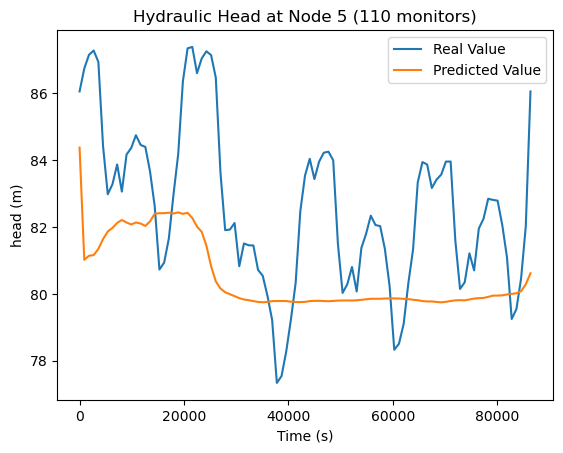

In [48]:
head_at_node5 = head.loc[:,'node_0005']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")
Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (110 monitors)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (110 monitors).png')
plt.show()

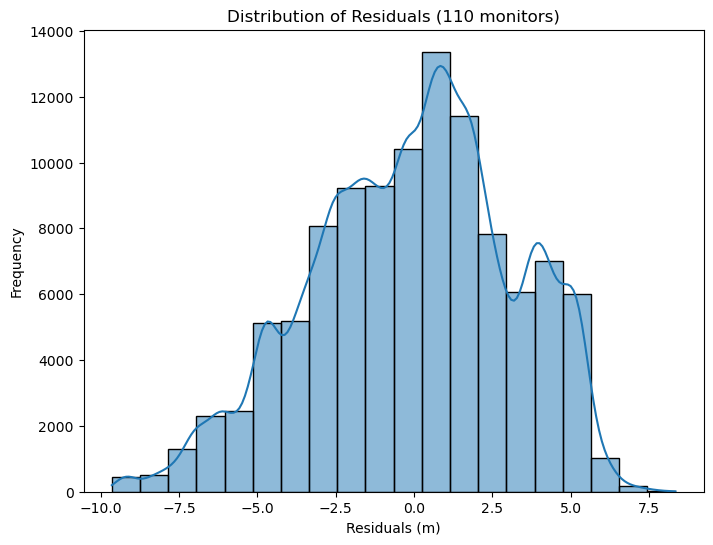

In [41]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.title('Distribution of Residuals (110 monitors)')
plt.savefig('Distribution of Residuals (110 monitors).png')
plt.show()

In [42]:
RESI = ana[ana['node'].isin(monitor)]['residuals']
Other_RESI = ana[~ana['node'].isin(monitor)]['residuals']

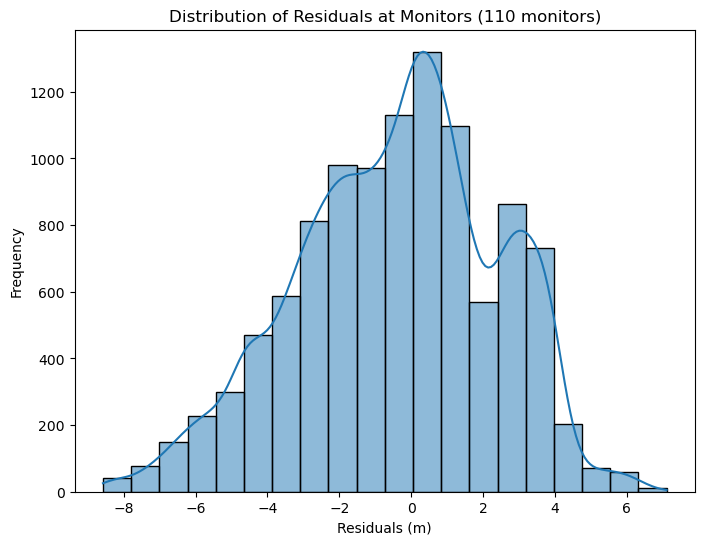

In [43]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(RESI, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals at Monitors (110 monitors)')

plt.savefig('Distribution of Residuals at Monitors (110 monitors).png')
plt.show()

In [ ]:
new_value = pd.Series([3000])
# Concatenate the two Series
monitor = pd.concat([monitor, new_value], ignore_index=True)
RESI = np.array(RESI).reshape((-1, 111))
RESI_df = pd.DataFrame(RESI[:111], columns=['Node ' + str(i) for i in monitor])
RESI_df.rename(columns={'Node 3000': 'Reservoir 1'}, inplace=True)

In [44]:
residuals.max()

8.342948913574219

In [45]:
residuals.min()

-9.643402099609375

In [46]:
RESI.max()

7.1118316650390625

In [47]:
RESI.min()

-8.577491760253906

In [16]:
Pre = pd.read_csv('45%-L.csv')
residuals =  head_df['head']- (Pre['0'])

ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': Pre['0'],
    'residuals': residuals
})
RESI = ana[ana['node'].isin(monitor)]['residuals']

In [17]:
RESI.abs().min()

9.311523442079306e-06

In [18]:
RESI.abs().max()

2.4032974057617196

In [19]:
residuals.abs().min()

5.808105470350711e-06

In [20]:
residuals.abs().max()

9.417384047851556